### main.ipynb
- load data
- train model

In [1]:
import re
import os
import gendata_new
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, TopKPooling
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import degree

import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CWE = 190
CWE = str(CWE)

In [3]:
# start time log
time_start = time.time()

# load data -> Dataset
data_path_good = r"D:\Desktop\hybrid-SVD\datasrc\CWE{}\goodres\dot".format(CWE)
data_path_bad = r"D:\Desktop\hybrid-SVD\datasrc\CWE{}\badres\dot".format(CWE)

Dataset = gendata_new.gendata(data_path_good)
Dataset = Dataset + gendata_new.gendata(data_path_bad)

random.shuffle(Dataset)

lenDataset = len(Dataset)
len_Trainset = int(0.7 * lenDataset)
len_Testset = int(0.2 * lenDataset)
len_Validateset = lenDataset - len_Testset - len_Trainset
Trainset = Dataset[:len_Trainset]
Testset = Dataset[len_Trainset :  len_Trainset+len_Testset]
Validset = Dataset[len_Trainset+len_Testset:]
print(f"len of dataset:{lenDataset}, \
        len of train:{len_Trainset}, \
        len of validate:{len_Validateset}, \
        len of test:{len_Testset}")

# dataset -> loader
train_loader = DataLoader(Trainset, batch_size=32, drop_last=True)
test_loader = DataLoader(Testset, batch_size=32, drop_last=True)
good = 0
bad = 0
for test in Testset:
    if test["y"] == 1:
        good += 1
    else:
        bad += 1
print(f"good in testset:{good};;bad in testset:{bad}")

# fin load ; print time span
time_fin_load = time.time()
print("data load time: ", time_fin_load-time_start)

len of dataset:6840,         len of train:4788,         len of validate:684,         len of test:1368
good in testset:710;;bad in testset:658
data load time:  217.59242606163025


In [4]:
# GCN layer
# cite: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__(aggr='add', **kwargs)  # "Add" aggregation (Step 5).
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x[N, in_channels]
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index

        deg = degree(col, x.size(0), dtype=x.dtype)

        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return  self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out

In [5]:
# Whole NN model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(256, 256)
        # self.conv1 = GraphConv(128, 128)
        self.pool1 = TopKPooling(256, ratio=0.8)
        self.conv2 = GCNConv(256, 256)
        # self.conv2 = GraphConv(128, 128)
        self.pool2 = TopKPooling(256, ratio=0.8)
        self.conv3 = GCNConv(256, 256)
        # self.conv3 = GraphConv(128, 128)
        self.pool3 = TopKPooling(256, ratio=0.8)
        self.conv4 = GCNConv(256, 256)
        self.pool4 = TopKPooling(256, ratio=0.8)
        self.conv5 = GCNConv(256, 256)
        self.pool5 = TopKPooling(256, ratio=0.8)

        self.convAtt1 = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=1, stride=2)
        self.poolAtt1 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt2 = torch.nn.Conv1d(64, 16, kernel_size=1, stride=2)
        self.poolAtt2 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt3 = torch.nn.Conv1d(16, 2, kernel_size=1, stride=2)
        self.poolAtt3 = torch.nn.MaxPool1d(kernel_size=1, stride=2)

        self.convAtt4 = torch.nn.Conv1d(2, 16, kernel_size=1, stride=2)
        self.poolAtt4 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt5 = torch.nn.Conv1d(16, 64, kernel_size=1, stride=2)
        self.poolAtt5 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
        self.convAtt6 = torch.nn.Conv1d(64, 512, kernel_size=1, stride=2)
        self.poolAtt6 = torch.nn.MaxPool1d(kernel_size=1, stride=2)

        self.lin1 = torch.nn.Linear(512, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 2)

        self.readout = Seq(Linear(128, 64),
                           ReLU(),
                           Linear(64, 2))

    def forward(self, x, edge_index, batch):
        # x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv4(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        x4 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = F.relu(self.conv5(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool5(x, edge_index, None, batch)
        x5 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

        x = x1 + x2 + x3 + x4 + x5

        x = 1/5 * x

        sx = x

        x = x.unsqueeze(dim=2)
        # attention层
        x = F.relu(self.convAtt1(x))
        x = self.poolAtt1(x)
        x = F.relu(self.convAtt2(x))
        x = self.poolAtt2(x)
        x = F.relu(self.convAtt3(x))
        x = self.poolAtt3(x)

        x = F.relu(self.convAtt4(x))
        x = self.poolAtt4(x)
        x = F.relu(self.convAtt5(x))
        x = self.poolAtt5(x)
        x = F.relu(self.convAtt6(x))
        x = self.poolAtt6(x)

        x = x.squeeze()

        x = (x + 1) * sx

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        x, edge_index, batch = data.x, data.edge_index, data.batch
        output = model(x, edge_index, batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(Trainset)

In [8]:
def test(t_loader):
    model.eval()
    correct = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    pred_good = 0
    pred_bad = 0
    for data in t_loader:
        data = data.to(device)
        x, edge_index, batch = data.x, data.edge_index, data.batch
        preds = model(x, edge_index, batch).max(dim=1)[1]
        correct += preds.eq(data.y).sum().item()
        for i in range(len(preds)):
            if preds[i] == 0 and data.y[i] == 0:
                tp += 1
                pred_bad += 1
            elif preds[i] == 0 and data.y[i] == 1:
                fp += 1
                pred_bad += 1
            elif preds[i] == 1 and data.y[i] == 1:
                tn += 1
                pred_good += 1
            elif preds[i] == 1 and data.y[i] == 0:
                fn += 1
                pred_good += 1
    acc = (tp + tn) / (tp + tn + fp + fn)
    return round(acc, 6), tp, fp, tn, fn, pred_good, pred_bad

In [9]:
# train & test
# time log
time_start = time.time()

train_loss_a = np.zeros(200)
test_acc_a = np.zeros(200)
for epoch in range(0, 200):
    loss = train(epoch)
    if epoch % 10 == 0:
        train_acc, tp, fp, tn, fn, pred_good, pred_bad = test(train_loader)
        test_acc, tp, fp, tn, fn, pred_good, pred_bad = test(test_loader)
        train_loss_a[epoch] = loss
        test_acc_a[epoch] = test_acc
        print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f},Test Acc: {:.5f}, TP: {:02d}, FP: {:02d}, TN: {:02d}, FN: {:02d}, Pred_good: {:04d}, Pred_bad: {:04d}'.
            format(epoch, loss, train_acc, test_acc, tp, fp, tn, fn, pred_good, pred_bad))

# fin train & test;;print time span
time_fin_train = time.time()
print("train & test time span : ", time_fin_train - time_start)

Epoch: 000, Loss: 0.42867, Train Acc: 0.86577,Test Acc: 0.86905, TP: 631, FP: 155, TN: 537, FN: 21, Pred_good: 0558, Pred_bad: 0786
Epoch: 010, Loss: 0.17343, Train Acc: 0.89681,Test Acc: 0.89807, TP: 557, FP: 42, TN: 650, FN: 95, Pred_good: 0745, Pred_bad: 0599
Epoch: 020, Loss: 0.31506, Train Acc: 0.89828,Test Acc: 0.89658, TP: 551, FP: 38, TN: 654, FN: 101, Pred_good: 0755, Pred_bad: 0589
Epoch: 030, Loss: 0.14673, Train Acc: 0.90604,Test Acc: 0.90848, TP: 584, FP: 55, TN: 637, FN: 68, Pred_good: 0705, Pred_bad: 0639
Epoch: 040, Loss: 0.14399, Train Acc: 0.90898,Test Acc: 0.90923, TP: 610, FP: 80, TN: 612, FN: 42, Pred_good: 0654, Pred_bad: 0690
Epoch: 050, Loss: 0.14314, Train Acc: 0.90898,Test Acc: 0.90030, TP: 600, FP: 82, TN: 610, FN: 52, Pred_good: 0662, Pred_bad: 0682
Epoch: 060, Loss: 0.14131, Train Acc: 0.91170,Test Acc: 0.90699, TP: 625, FP: 98, TN: 594, FN: 27, Pred_good: 0621, Pred_bad: 0723
Epoch: 070, Loss: 0.14638, Train Acc: 0.91170,Test Acc: 0.90848, TP: 634, FP: 105

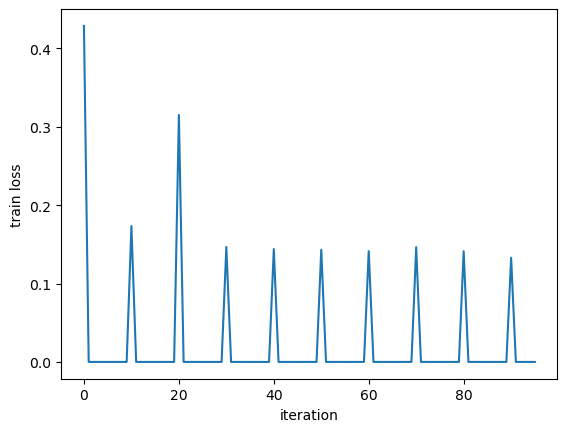

In [10]:
path = os.getcwd()
x = np.arange(0, 96, 1)
plt.xlabel("iteration")
plt.ylabel("train loss")
plt.plot(x, train_loss_a[0:96])